## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\laogoon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.01, l2_ratio=0.01):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 46us/step - loss: 6.0048 - acc: 0.2731 - val_loss: 5.8123 - val_acc: 0.3423
Epoch 2/50
50000/50000 [==============================] - 2s 40us/step - loss: 5.7258 - acc: 0.3651 - val_loss: 5.6455 - val_acc: 0.3815
Epoch 3/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.5782 - acc: 0.3952 - val_loss: 5.5264 - val_acc: 0.3969
Epoch 4/50
50000/50000 [==============================] - 2s 40us/step - loss: 5.4575 - acc: 0.4144 - val_loss: 5.4001 - val_acc: 0.4209
Epoch 5/50
50000/50000 [==============================] - 2s 40us/step - loss: 5.3480 - acc: 0.4307 - val_loss: 5.3052 - val_acc: 0.4295
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 5.2469 - acc: 0.4439 - val_loss: 5.2061 - val_acc: 0.4451
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 5.1534 - acc: 0.4561 - val_loss: 5.1219 - val_acc

50000/50000 [==============================] - 2s 40us/step - loss: 1.8060 - acc: 0.3690 - val_loss: 1.7565 - val_acc: 0.3845
Epoch 3/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7195 - acc: 0.3961 - val_loss: 1.6911 - val_acc: 0.4064
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.6627 - acc: 0.4168 - val_loss: 1.6412 - val_acc: 0.4274
Epoch 5/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6162 - acc: 0.4322 - val_loss: 1.5986 - val_acc: 0.4385
Epoch 6/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5780 - acc: 0.4480 - val_loss: 1.5779 - val_acc: 0.4416
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5454 - acc: 0.4568 - val_loss: 1.5633 - val_acc: 0.4487
Epoch 8/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5166 - acc: 0.4675 - val_loss: 1.5349 - val_acc: 0.4567
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 2s 40us/step - loss: 1.7203 - acc: 0.3964 - val_loss: 1.6919 - val_acc: 0.4071
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.6603 - acc: 0.4166 - val_loss: 1.6406 - val_acc: 0.4237
Epoch 5/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6109 - acc: 0.4353 - val_loss: 1.6061 - val_acc: 0.4345
Epoch 6/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5710 - acc: 0.4503 - val_loss: 1.5631 - val_acc: 0.4493
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5369 - acc: 0.4616 - val_loss: 1.5457 - val_acc: 0.4515
Epoch 8/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5056 - acc: 0.4735 - val_loss: 1.5229 - val_acc: 0.4609
Epoch 9/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4798 - acc: 0.4810 - val_loss: 1.4986 - val_acc: 0.4657
Epoch 10/50
50000/50000 [===========================

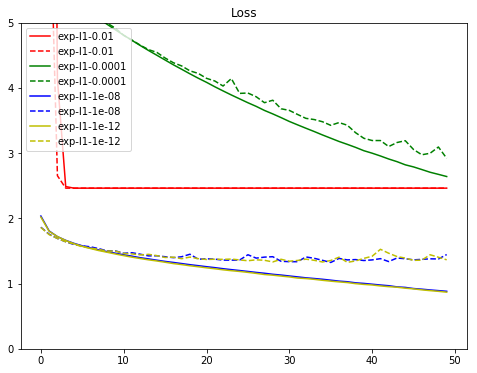

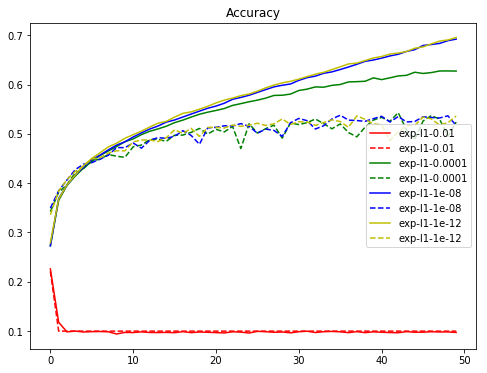

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
results = {}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp2(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio, l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 52us/step - loss: 6.1537 - acc: 0.2666 - val_loss: 5.9519 - val_acc: 0.3404
Epoch 2/50
50000/50000 [==============================] - 2s 42us/step - loss: 5.8609 - acc: 0.3637 - val_loss: 5.7828 - val_acc: 0.3812
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 5.7047 - acc: 0.3939 - val_loss: 5.6354 - val_acc: 0.4094
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 5.5757 - acc: 0.4146 - val_loss: 5.5173 - val_acc: 0.4144
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 5.4589 - acc: 0.4320 - val_loss: 5.4033 - val_acc: 0.4388
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 5.3508 - acc: 0.4420 - val_loss: 5.3028 - val_acc: 0.4452
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 5.2503 - acc: 0.4545 - val_loss: 5.2130 - val_acc

50000/50000 [==============================] - 2s 42us/step - loss: 1.8179 - acc: 0.3629 - val_loss: 1.7717 - val_acc: 0.3809
Epoch 3/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.7368 - acc: 0.3912 - val_loss: 1.7045 - val_acc: 0.4066
Epoch 4/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.6791 - acc: 0.4117 - val_loss: 1.6502 - val_acc: 0.4246
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.6309 - acc: 0.4300 - val_loss: 1.6146 - val_acc: 0.4360
Epoch 6/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5893 - acc: 0.4443 - val_loss: 1.5731 - val_acc: 0.4462
Epoch 7/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5541 - acc: 0.4556 - val_loss: 1.5614 - val_acc: 0.4446
Epoch 8/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5241 - acc: 0.4658 - val_loss: 1.5273 - val_acc: 0.4606
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 2s 42us/step - loss: 1.7147 - acc: 0.4013 - val_loss: 1.6891 - val_acc: 0.4080
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.6579 - acc: 0.4214 - val_loss: 1.6435 - val_acc: 0.4201
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.6125 - acc: 0.4362 - val_loss: 1.6039 - val_acc: 0.4353
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.5747 - acc: 0.4477 - val_loss: 1.5671 - val_acc: 0.4503
Epoch 7/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5424 - acc: 0.4608 - val_loss: 1.5431 - val_acc: 0.4555
Epoch 8/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5134 - acc: 0.4715 - val_loss: 1.5398 - val_acc: 0.4514
Epoch 9/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.4867 - acc: 0.4807 - val_loss: 1.5188 - val_acc: 0.4620
Epoch 10/50
50000/50000 [===========================

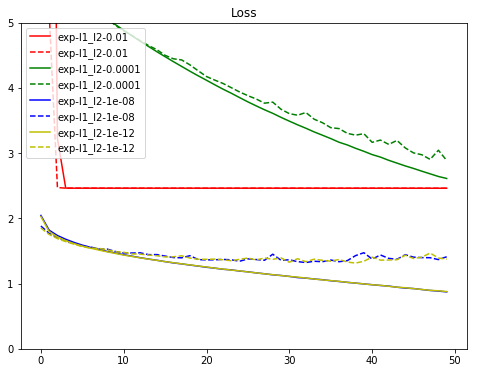

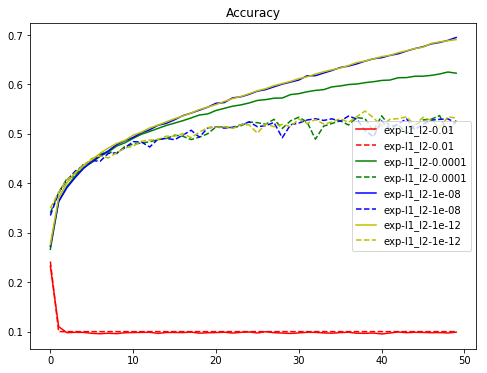

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()